In [2]:
def compute_edge_map(mask):
    edges = torch.zeros_like(mask, dtype=torch.float32)
    mask_np = mask.cpu().numpy()
    for i in range(mask.shape[0]):
        edges[i] = torch.from_numpy(cv2.Canny(mask_np[i].astype(np.uint8), 50, 150))
    return edges

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset 
import json
import cv2
import numpy as np
from PIL import Image
import os
from torchvision.ops import nms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm



/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
NUM_CLASSES = 10 
LANE_CLASSES = 2 
IMG_SIZE = 512   

In [4]:
class ImprovedLaneDecoderWithSkipConnections(nn.Module):
    def __init__(self):
        super(ImprovedLaneDecoderWithSkipConnections, self).__init__()
        
        # Improved decoder blocks with residual connections
        self.decode4 = ImprovedDecoderBlock(512, 256)
        self.decode3 = ImprovedDecoderBlock(256 + 256, 128)
        self.decode2 = ImprovedDecoderBlock(128 + 128, 64)
        self.decode1 = ImprovedDecoderBlock(64 + 64, 32)
        
        # Additional refinement blocks
        self.refinement = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Attention modules
        self.attention4 = SpatialAttention(256)
        self.attention3 = SpatialAttention(128)
        self.attention2 = SpatialAttention(64)
        
        # Edge detection branch
        self.edge_branch = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=1)
        )
        
        # Final classifier with larger receptive field
        self.final_conv = nn.Sequential(
            nn.Conv2d(32 + 1, 32, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=4, dilation=4),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, LANE_CLASSES, kernel_size=1)
        )
        
    def forward(self, x5, x4, x3, x2, x1):
        # Decoder with attention and skip connections
        d4 = self.decode4(x5)
        d4_att = self.attention4(d4)
        
        d3 = self.decode3(torch.cat([d4_att, x4], dim=1))
        d3_att = self.attention3(d3)
        
        d2 = self.decode2(torch.cat([d3_att, x3], dim=1))
        d2_att = self.attention2(d2)
        
        d1 = self.decode1(torch.cat([d2_att, x2], dim=1))
        
        # Refinement
        refined = self.refinement(d1)
        
        # Edge detection
        edges = self.edge_branch(refined)
        
        # Combine features with edge information
        combined = torch.cat([refined, edges], dim=1)
        
        # Final classification
        out = self.final_conv(combined)
        
        # Bilinear upsampling to match input resolution
        out = F.interpolate(out, size=(512, 512), mode='bilinear', align_corners=False)
        edges = F.interpolate(edges, size=(512, 512), mode='bilinear', align_corners=False)
        return out, edges

In [5]:
class SimpleMTLModel(nn.Module):
    def __init__(self):
        super(SimpleMTLModel, self).__init__()
        backbone = models.resnet18(pretrained=True)

        self.conv1 = backbone.conv1
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool
        self.layer1 = backbone.layer1 
        self.layer2 = backbone.layer2 
        self.layer3 = backbone.layer3 
        self.layer4 = backbone.layer4 
        
        # Object Detection Head (kept the same)
        self.obj_conv = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.obj_head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, (5 + NUM_CLASSES) * 9, kernel_size=1)
        )
        
        # Improved Lane Detection Head with skip connections
        self.lane_decoder = ImprovedLaneDecoderWithSkipConnections()
        
        # Lane Detection Head (Improved with upsampling)
    def forward(self, x):
        # Initial layers
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        
        # Backbone features with intermediate outputs
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        
        # Object Detection Branch
        obj_feat = self.obj_conv(x5)
        obj_output = self.obj_head(obj_feat)
        B, C, H, W = obj_output.shape
        obj_output = obj_output.view(B, 9, -1, H, W)
        
        # Lane Detection Branch with skip connections
        lane_output, edge_output = self.lane_decoder(x5, x4, x3, x2, x1)
        
        return obj_output, lane_output, edge_output

In [6]:
class ImprovedDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImprovedDecoderBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual connection
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        
        # Improved upsampling with learnable parameters
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        identity = self.residual(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add residual connection
        out = out + identity
        out = self.relu(out)
        
        # Upsample
        out = self.upsample(out)
        return out

In [7]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1),
            nn.BatchNorm2d(in_channels // 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attention = self.conv(x)
        return x * attention

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [9]:
class ImprovedLossFunction(nn.Module):
    def __init__(self, edge_weight=0.5):
        super(ImprovedLossFunction, self).__init__()
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2)
        self.edge_weight = edge_weight
        self.bce_loss = nn.BCEWithLogitsLoss()
        
    def forward(self, pred_lanes, pred_edges, true_lanes, true_edges):
        # Segmentation loss with focal loss
        seg_loss = self.focal_loss(pred_lanes, true_lanes)
        
        # Edge loss with BCE
        edge_loss = self.bce_loss(pred_edges, true_edges)
        
        # Combine losses
        total_loss = seg_loss + self.edge_weight * edge_loss
        return total_loss

In [10]:

SUBSET_SIZE = 100  # Number of images to use for training

# Category to index mapping (adjust based on your categories)
CATEGORY_TO_IDX = {
    'car': 0,
    'truck': 1,
    'bus': 2,
    'person': 3,
    'rider': 4,
    'bike': 5,
    'motor': 6,
    'traffic light': 7,
    'traffic sign': 8,
    'train': 9
}
def validate_and_normalize_lane_mask(lane_mask):
    if torch.is_tensor(lane_mask):
        lane_mask = torch.clamp(lane_mask, 0, LANE_CLASSES-1)
    else:
        lane_mask = np.clip(lane_mask, 0, LANE_CLASSES-1)
    return lane_mask

In [11]:
class BDD100KDataset(Dataset):
    def __init__(self, root_dir, det_json, lane_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.lane_dir = lane_dir
        
        # Load detection annotations
        with open(det_json, 'r') as f:
            self.det_anns = json.load(f)
            
        # Get image list
        self.images = [ann['name'] for ann in self.det_anns]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Initialize empty lists for boxes and labels
        boxes = []
        class_labels = []
        
        try:
            # Load image
            img_name = self.images[idx]
            img_path = os.path.join(self.root_dir, img_name)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Could not load image at {img_path}")
                return self.get_empty_sample()
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load lane mask
            mask_name = img_name.replace('.jpg', '.png')
            mask_path = os.path.join(self.lane_dir, mask_name)
            lane_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if lane_mask is None:
                print(f"Could not load mask at {mask_path}")
                return self.get_empty_sample()
                
            # Ensure mask values are binary (0 or 1)
            lane_mask = (lane_mask > 0).astype(np.uint8)
            
            # Get detection annotations
            det_ann = self.det_anns[idx]
            if 'labels' in det_ann:  # Check if labels exist
                for obj in det_ann['labels']:
                    if 'box2d' in obj and obj['category'] in CATEGORY_TO_IDX:
                        x1 = obj['box2d']['x1']
                        y1 = obj['box2d']['y1']
                        x2 = obj['box2d']['x2']
                        y2 = obj['box2d']['y2']
                        
                        # Skip invalid boxes
                        if x2 <= x1 or y2 <= y1:
                            continue
                            
                        boxes.append([x1, y1, x2, y2])
                        class_labels.append(CATEGORY_TO_IDX[obj['category']])
            
            # If no valid boxes were found, use a dummy box that will be filtered out
            if len(boxes) == 0:
                boxes = [[0, 0, 1, 1]]
                class_labels = [0]
            
            # Apply transforms
            if self.transform:
                transformed = self.transform(
                    image=image,
                    mask=lane_mask,
                    bboxes=boxes,
                    class_labels=class_labels
                )
                
                image = transformed['image']
                lane_mask = transformed['mask']
                boxes = transformed['bboxes']
                class_labels = transformed['class_labels']
            
            # Verify dimensions
            if isinstance(image, torch.Tensor):
                assert image.shape[-2:] == (512, 512), \
                    f"Image has wrong dimensions: {image.shape}"
            if isinstance(lane_mask, torch.Tensor):
                assert lane_mask.shape[-2:] == (512, 512), \
                    f"Mask has wrong dimensions: {lane_mask.shape}"
            
            # Convert to tensors if not already
            if not isinstance(image, torch.Tensor):
                image = torch.tensor(image, dtype=torch.float32)
            if not isinstance(lane_mask, torch.Tensor):
                lane_mask = torch.tensor(lane_mask, dtype=torch.long)
            
            boxes = torch.tensor(boxes, dtype=torch.float32)
            class_labels = torch.tensor(class_labels, dtype=torch.long)
            
            return {
                'image': image,
                'boxes': boxes,
                'labels': class_labels,
                'lane_mask': lane_mask
            }
            
        except Exception as e:
            print(f"Error processing {self.images[idx]}: {str(e)}")
            return self.get_empty_sample()

In [12]:
def get_transform(train=True):
    if train:
        transform = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['class_labels'],
            min_visibility=0.3
        ))
    else:
        transform = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['class_labels'],
            min_visibility=0.3
        ))
    return transform

In [13]:
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    lane_masks = torch.stack([item['lane_mask'] for item in batch])
    
    # Boxes and labels are returned as lists since they have different sizes
    boxes = [item['boxes'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    return {
        'image': images,
        'boxes': boxes,
        'labels': labels,
        'lane_mask': lane_masks
    }

In [14]:
class DetectionLoss(nn.Module):
    def __init__(self):
        super(DetectionLoss, self).__init__()
        self.l1_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, predictions, targets):
        loc_loss = self.l1_loss(predictions[..., :4], targets[..., :4])
        conf_loss = self.bce_loss(predictions[..., 4], targets[..., 4])
        cls_loss = self.ce_loss(predictions[..., 5:], targets[..., 5:])
        return loc_loss + conf_loss + cls_loss
    
def compute_edge_weights(masks, kernel_size=3):
    B, H, W = masks.shape
    kernel = torch.ones(1, 1, kernel_size, kernel_size).to(masks.device)
    masks_expanded = masks.unsqueeze(1).float()
    
    # Dilated masks
    dilated = F.conv2d(masks_expanded, kernel, padding=kernel_size//2) > 0
    # Eroded masks
    eroded = F.conv2d(masks_expanded, kernel, padding=kernel_size//2) == kernel_size**2
    
    # Edge is where dilated and eroded differ
    edges = (dilated != eroded).float().squeeze(1)
    
    weight_map = torch.ones_like(masks, dtype=torch.float32)
    weight_map[edges > 0] = 5.0  # Increase weight for edge pixels
    
    return weight_map

In [15]:
def train_one_epoch(model, dataloader, optimizer, device, scaler):
    model.train()
    focal_loss = FocalLoss().to(device)
    det_loss_fn = DetectionLoss()
    
    total_loss = 0
    lane_correct = 0
    total_pixels = 0
    
    for batch_idx, batch in enumerate(dataloader):
        try:
            images = batch['image'].to(device)
            lane_masks = batch['lane_mask'].to(device)
            boxes = [b.to(device) for b in batch['boxes']]
            labels = [l.to(device) for l in batch['labels']]
            
            # Verify input dimensions
            B, C, H, W = images.shape
            assert H == W == 512, f"Expected input size 512x512, got {H}x{W}"
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                det_out, lane_out = model(images)
                
                # Verify output dimensions
                assert lane_out.shape[-2:] == (512, 512), \
                    f"Expected lane output size 512x512, got {lane_out.shape[-2]}x{lane_out.shape[-1]}"
                
                lane_loss = focal_loss(lane_out, lane_masks)
                
                # Add edge-aware weight to focus on lane boundaries
                edge_weight = compute_edge_weights(lane_masks)
                lane_loss = lane_loss * edge_weight.to(device)
                
                loss = lane_loss
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            with torch.no_grad():
                lane_pred = torch.argmax(lane_out, dim=1)
                lane_correct += (lane_pred == lane_masks).sum().item()
                total_pixels += lane_masks.numel()
                
        except Exception as e:
            print(f"Error in training batch {batch_idx}: {str(e)}")
            continue
    
    avg_loss = total_loss / len(dataloader)
    lane_accuracy = lane_correct / total_pixels if total_pixels > 0 else 0
    
    return avg_loss, lane_accuracy

In [16]:
def validate_one_epoch(model, dataloader, device):
    model.eval()
    seg_loss_fn = nn.CrossEntropyLoss()
    
    total_loss = 0
    lane_correct = 0
    total_pixels = 0
    
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            lane_masks = batch['lane_mask'].to(device)
            
            det_out, lane_out = model(images)
            
            # Calculate lane segmentation loss
            lane_loss = seg_loss_fn(lane_out, lane_masks)
            
            # Calculate metrics
            lane_pred = torch.argmax(lane_out, dim=1)
            lane_correct += (lane_pred == lane_masks).sum().item()
            total_pixels += lane_masks.numel()
            
            total_loss += lane_loss.item()
    
    avg_loss = total_loss / len(dataloader)
    lane_accuracy = lane_correct / total_pixels
    
    return avg_loss, lane_accuracy

def save_checkpoint(model, optimizer, epoch, best_loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss,
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    return model, optimizer, epoch, best_loss

In [17]:
class Inferencer:
    def __init__(self, model, device, confidence_threshold=0.5, nms_threshold=0.45):
        self.model = model
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.nms_threshold = nms_threshold
    
    def postprocess_lanes(self, lane_out, orig_dims):

        lane_pred = torch.softmax(lane_out, dim=1)  # Apply softmax to get probabilities
        lane_pred = torch.argmax(lane_pred, dim=1).squeeze(0)
        
        # Resize to original dimensions
        orig_h, orig_w = orig_dims
        lane_pred = F.interpolate(
            lane_pred.float().unsqueeze(0).unsqueeze(0),
            size=(orig_h, orig_w),
            mode='nearest'
        ).squeeze().cpu().numpy()
        
        return lane_pred
    
    def postprocess_detections(self, det_out, orig_dims):
        # Reshape detection output
        det_out = det_out.squeeze(0)  # Remove batch dimension
        boxes = det_out[..., :4]
        scores = det_out[..., 4].sigmoid()
        class_scores = det_out[..., 5:].softmax(-1)
        
        # Filter by confidence
        mask = scores > self.confidence_threshold
        boxes = boxes[mask]
        scores = scores[mask]
        class_scores = class_scores[mask]
        
        if len(boxes) == 0:
            return [], [], []
        
        # Get class predictions
        class_ids = torch.argmax(class_scores, dim=1)
        
        # Apply NMS
        keep_indices = nms(boxes, scores, self.nms_threshold)
        
        boxes = boxes[keep_indices]
        scores = scores[keep_indices]
        class_ids = class_ids[keep_indices]
        
        # Scale boxes to original image size
        orig_h, orig_w = orig_dims
        scale_x = orig_w / IMG_SIZE
        scale_y = orig_h / IMG_SIZE
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y
        
        return boxes.cpu().numpy(), scores.cpu().numpy(), class_ids.cpu().numpy()
    
    def postprocess_lanes(self, lane_out, orig_dims):
        # Get lane predictions
        lane_pred = torch.argmax(lane_out, dim=1).squeeze(0)
        
        # Resize to original dimensions
        orig_h, orig_w = orig_dims
        lane_pred = F.interpolate(
            lane_pred.float().unsqueeze(0).unsqueeze(0),
            size=(orig_h, orig_w),
            mode='nearest'
        ).squeeze().cpu().numpy()
        
        return lane_pred
    
    def visualize_results(self, image, det_out, lane_out):
        # Process lane predictions
        lane_pred = torch.softmax(lane_out, dim=1)
        lane_pred = torch.argmax(lane_pred, dim=1).squeeze(0).cpu().numpy()
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        # Original image with detections
        ax1.imshow(image)
        # Add detection boxes here if needed
        ax1.set_title('Original Image with Detections')
        
        # Lane predictions
        lane_overlay = np.zeros_like(image)
        lane_overlay[lane_pred == 1] = [0, 1, 0]  # Green for lanes
        ax2.imshow(image)
        ax2.imshow(lane_overlay, alpha=0.5)
        ax2.set_title('Lane Predictions')
        
        plt.show()

    def __call__(self, image_path):
        self.model.eval()
        
        with torch.no_grad():
            # Preprocess image
            image_tensor, orig_dims = self.preprocess_image(image_path)
            
            # Forward pass
            det_out, lane_out = self.model(image_tensor)
            
            # Postprocess outputs
            boxes, scores, class_ids = self.postprocess_detections(det_out, orig_dims)
            lane_mask = self.postprocess_lanes(lane_out, orig_dims)
            
            # Visualize results
            result_image = self.visualize_results(image_path, boxes, scores, class_ids, lane_mask)
            
            return result_image, boxes, scores, class_ids, lane_mask

In [18]:
def validate_lane_detection(model, val_loader, device):

    model.eval()
    total_iou = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            lane_masks = batch['lane_mask'].to(device)
            
            # Forward pass
            _, lane_out = model(images)
            
            # Get predictions
            lane_preds = torch.argmax(lane_out, dim=1)
            
            # Calculate IoU for each image in batch
            for pred, target in zip(lane_preds, lane_masks):
                intersection = torch.logical_and(pred, target).sum()
                union = torch.logical_or(pred, target).sum()
                if union > 0:
                    iou = intersection.float() / union.float()
                    total_iou += iou.item()
                    num_samples += 1
    
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    return avg_iou

In [19]:
def main():
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        # Create model
        model = SimpleMTLModel().to(device)
        
        # Create full datasets
        full_train_dataset = BDD100KDataset(
            root_dir='/kaggle/input/100kds/100k_images_train/bdd100k/images/100k/train',
            det_json='/kaggle/input/bdddet/bdd100k/labels/det_20/det_train.json',
            lane_dir='/kaggle/input/bdd100k/bdd100k_lane_labels_trainval/bdd100k/labels/lane/masks/train',
            transform=get_transform(train=True)
        )
        
        full_val_dataset = BDD100KDataset(
            root_dir='/kaggle/input/100kds/100k_images_val/bdd100k/images/100k/val',
            det_json='/kaggle/input/bdddet/bdd100k/labels/det_20/det_val.json',
            lane_dir='/kaggle/input/bdd100k/bdd100k_lane_labels_trainval/bdd100k/labels/lane/masks/val',
            transform=get_transform(train=False)
        )
        
        # Create subset indices
        train_indices = torch.randperm(len(full_train_dataset))[:SUBSET_SIZE]
        val_indices = torch.randperm(len(full_val_dataset))[:SUBSET_SIZE//5]
        
        # Create subset datasets
        train_dataset = Subset(full_train_dataset, train_indices)
        val_dataset = Subset(full_val_dataset, val_indices)
        
        print(f"Training on {len(train_dataset)} images")
        print(f"Validating on {len(val_dataset)} images")
        
        # Create data loaders with proper error handling
        train_loader = DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=0,  # Set to 0 to avoid potential multiprocessing issues
            collate_fn=collate_fn,
            pin_memory=True  # Enable pin memory for faster data transfer to GPU
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=4,
            shuffle=False,
            num_workers=0,
            collate_fn=collate_fn,
            pin_memory=True
        )
        
        # Training setup
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10
        best_val_loss = float('inf')
        scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
        
        # Load checkpoint if exists
        start_epoch = 0
        if os.path.exists('checkpoint.pth'):
            model, optimizer, start_epoch, best_val_loss = load_checkpoint(
                model, optimizer, 'checkpoint.pth'
            )
            print(f"Loaded checkpoint from epoch {start_epoch}")
        
        # Training loop
        for epoch in range(start_epoch, num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            
            # Train
            model.train()
            train_loss = 0
            train_steps = 0
            improved_loss_fn = ImprovedLossFunction(edge_weight=0.5)
            
            for batch in tqdm(train_loader, desc="Training"):
                try:
                    # Move batch to device
                    images = batch['image'].to(device, non_blocking=True)
                    lane_masks = batch['lane_mask'].to(device, non_blocking=True)
                    true_edges = compute_edge_map(lane_masks)
                    # Zero gradients
                    optimizer.zero_grad(set_to_none=True)
                    
                    # Forward pass with automatic mixed precision
                    with torch.cuda.amp.autocast():
                        det_out, lane_out, edge_out = model(images)
                        loss = improved_loss_fn(lane_out, edge_out, lane_masks, true_edges)
                    
                    # Backward pass with gradient scaling
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    train_loss += loss.item()
                    train_steps += 1
                    
                except RuntimeError as e:
                    continue
            
            avg_train_loss = train_loss / train_steps if train_steps > 0 else float('inf')
            
            # Validate
            model.eval()
            val_loss = 0
            val_steps = 0
            
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validating"):
                    try:
                        images = batch['image'].to(device, non_blocking=True)
                        lane_masks = batch['lane_mask'].to(device, non_blocking=True)
                        
                        with torch.cuda.amp.autocast():
                            det_out, lane_out, edge_out = model(images)
                            loss = improved_loss_fn(lane_out, edge_out, lane_masks, true_edges)
                        
                        val_loss += loss.item()
                        val_steps += 1
                        
                    except RuntimeError as e:
                        continue
            
            avg_val_loss = val_loss / val_steps if val_steps > 0 else float('inf')
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                save_checkpoint(model, optimizer, epoch, best_val_loss, 'best_model.pth')
                print("Saved best model checkpoint")
            
            # Save regular checkpoint
            save_checkpoint(model, optimizer, epoch, best_val_loss, 'checkpoint.pth')
    except Exception as e:
        print(f"Training failed with error: {str(e)}")

if __name__ == '__main__':
    main()

Using device: cpu


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]
/tmp/ipykernel_30/306596956.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.Grad

Training on 100 images
Validating on 20 images

Epoch 1/10


Training:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_30/306596956.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Validating:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_30/306596956.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]



Epoch 2/10


Validating: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]



Epoch 3/10


Validating: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]



Epoch 4/10


Validating: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]



Epoch 5/10


Validating: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]



Epoch 6/10


Validating: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]



Epoch 7/10


Validating: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]



Epoch 8/10


Validating: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]



Epoch 9/10


Validating: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]



Epoch 10/10


Validating: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Using device: cpu

Testing dataset with 10000 total samples

Sample 0:
Image shape: torch.Size([3, 512, 512])
Lane mask shape: torch.Size([512, 512])
Number of boxes: 33
Number of labels: 33


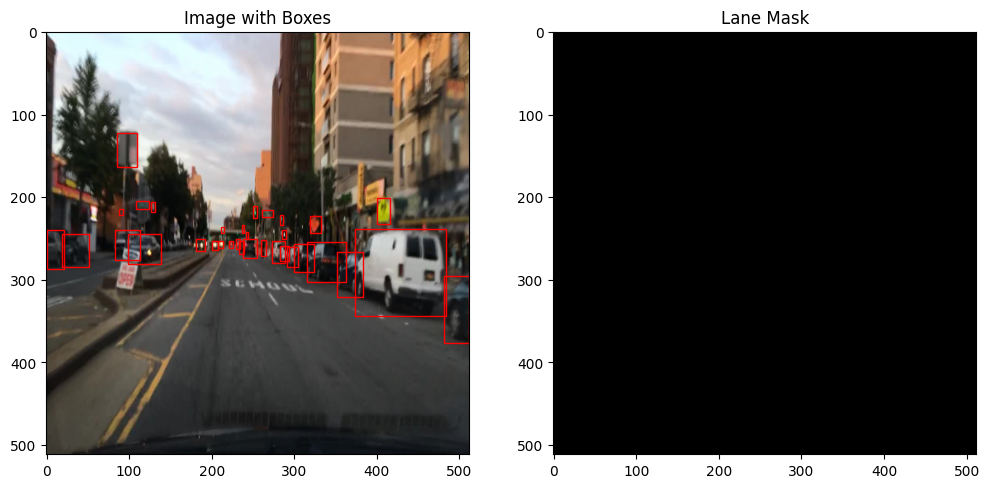


Sample 1:
Image shape: torch.Size([3, 512, 512])
Lane mask shape: torch.Size([512, 512])
Number of boxes: 4
Number of labels: 4


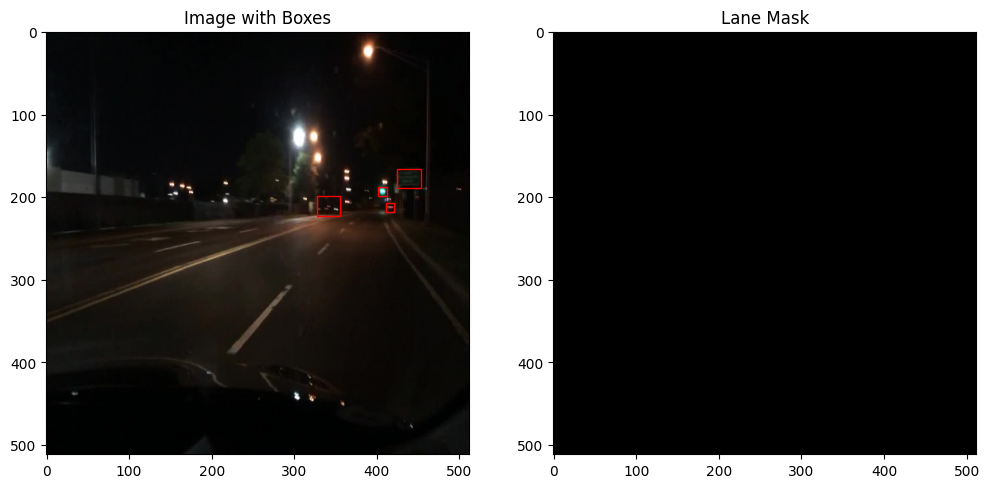


Sample 2:
Image shape: torch.Size([3, 512, 512])
Lane mask shape: torch.Size([512, 512])
Number of boxes: 14
Number of labels: 14


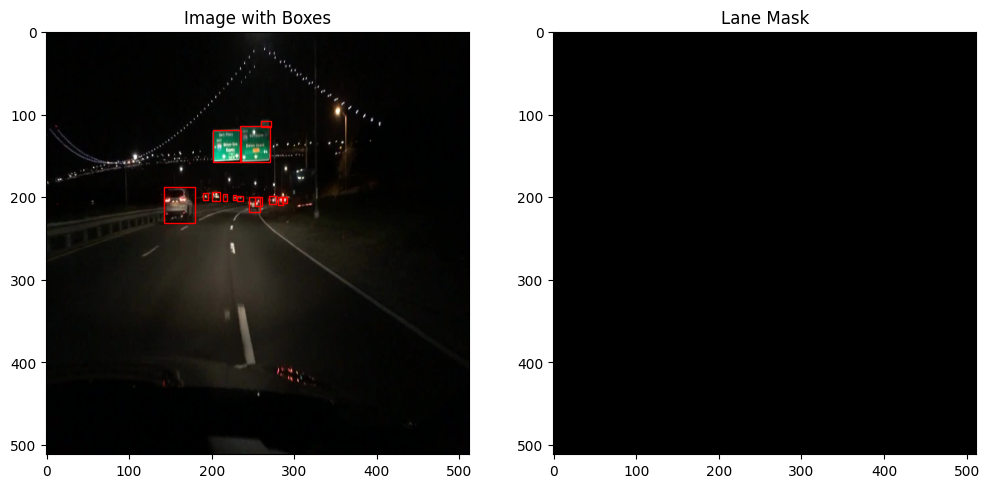


Sample 3:
Image shape: torch.Size([3, 512, 512])
Lane mask shape: torch.Size([512, 512])
Number of boxes: 19
Number of labels: 19


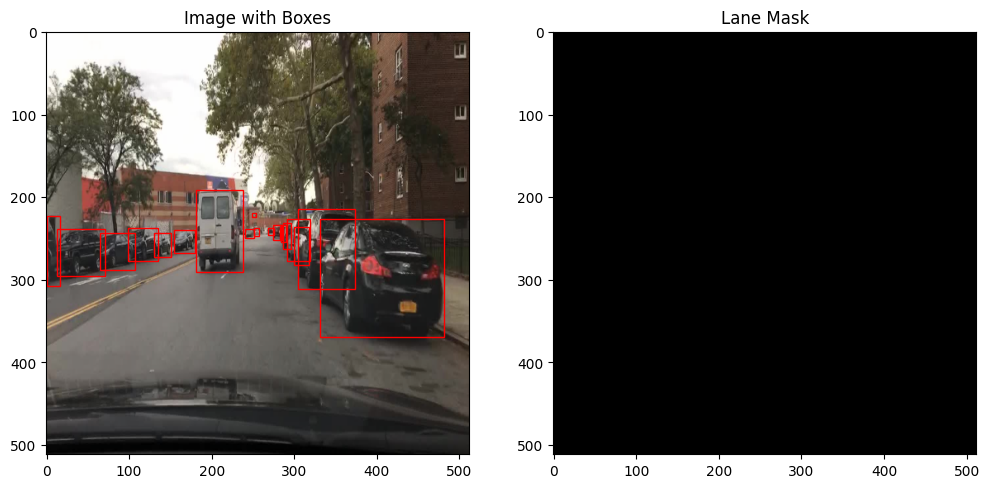


Sample 4:
Image shape: torch.Size([3, 512, 512])
Lane mask shape: torch.Size([512, 512])
Number of boxes: 17
Number of labels: 17


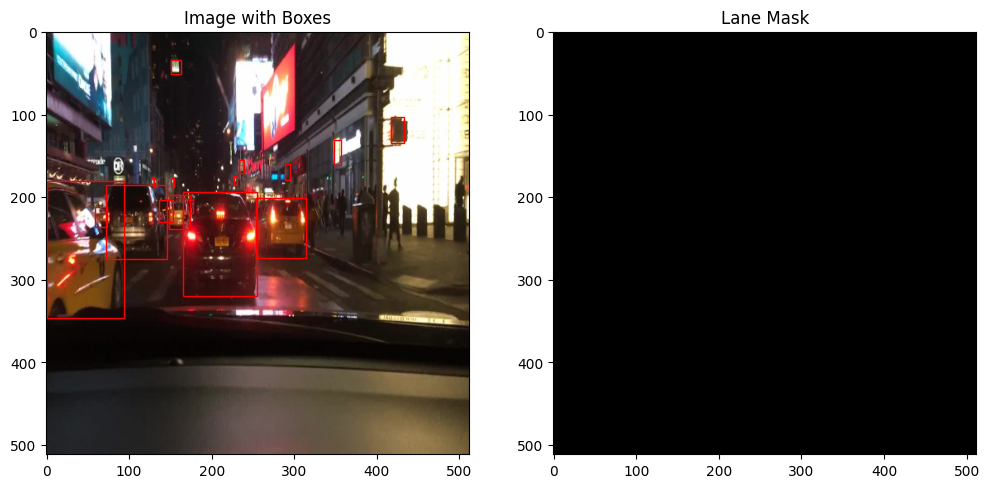


All tests completed successfully!


In [20]:
def test_dataset(dataset, num_samples=5):
    print(f"\nTesting dataset with {len(dataset)} total samples")
    
    for i in range(min(num_samples, len(dataset))):
        try:
            sample = dataset[i]
            
            # Print sample information
            print(f"\nSample {i}:")
            print(f"Image shape: {sample['image'].shape}")
            print(f"Lane mask shape: {sample['lane_mask'].shape}")
            print(f"Number of boxes: {len(sample['boxes'])}")
            print(f"Number of labels: {len(sample['labels'])}")
            
            # Convert tensor to numpy for visualization
            image = sample['image'].numpy().transpose(1, 2, 0)
            # Denormalize image
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image = np.clip(image, 0, 1)
            
            lane_mask = sample['lane_mask'].numpy()
            
            # Visualize
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            
            # Plot image with boxes
            ax1.imshow(image)
            for box in sample['boxes']:
                x1, y1, x2, y2 = box.numpy()
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red')
                ax1.add_patch(rect)
            ax1.set_title('Image with Boxes')
            
            # Plot lane mask
            ax2.imshow(lane_mask, cmap='gray')
            ax2.set_title('Lane Mask')
            
            plt.show()
            
        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            continue

def test_model(model, dataset, device, num_samples=3):

    model.eval()
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=2,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn
    )
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
                
            try:
                # Move batch to device
                images = batch['image'].to(device)
                lane_masks = batch['lane_mask'].to(device)
                
                # Forward pass
                det_out, lane_out = model(images)

                for b in range(images.shape[0]):
                    # Get original image
                    img = images[b].cpu().numpy().transpose(1, 2, 0)
                    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img = np.clip(img, 0, 1)
                    
                    # Get lane predictions
                    lane_pred = torch.softmax(lane_out[b], dim=0)
                    lane_pred = torch.argmax(lane_pred, dim=0).cpu().numpy()
                    
                    # Get ground truth
                    lane_gt = lane_masks[b].cpu().numpy()
                    
                    # Create visualization
                    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                    
                    # Original image
                    ax1.imshow(img)
                    ax1.set_title('Original Image')
                    ax1.axis('off')
                    
                    # Predicted lanes
                    lane_overlay = np.zeros_like(img)
                    lane_overlay[lane_pred == 1] = [0, 1, 0]  # Green for predicted lanes
                    ax2.imshow(img)
                    ax2.imshow(lane_overlay, alpha=0.5)
                    ax2.set_title('Predicted Lanes')
                    ax2.axis('off')
                    
                    # Ground truth lanes
                    gt_overlay = np.zeros_like(img)
                    gt_overlay[lane_gt == 1] = [1, 0, 0]  # Red for ground truth lanes
                    ax3.imshow(img)
                    ax3.imshow(gt_overlay, alpha=0.5)
                    ax3.set_title('Ground Truth Lanes')
                    ax3.axis('off')
                    
                    plt.show()
                
            except Exception as e:
                continue


def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        # Create dataset
        val_dataset = BDD100KDataset(
            root_dir='/kaggle/input/100kds/100k_images_val/bdd100k/images/100k/val',
            det_json='/kaggle/input/bdddet/bdd100k/labels/det_20/det_val.json',
            lane_dir='/kaggle/input/bdd100k/bdd100k_lane_labels_trainval/bdd100k/labels/lane/masks/val',
            transform=get_transform(train=False)
        )
        
        # Test dataset
        test_dataset(val_dataset)
        
        # Create model
        model = SimpleMTLModel().to(device)
        
        # Test model
        test_model(model, val_dataset, device)
        
        print("\nAll tests completed successfully!")
        
    except Exception as e:
        print(f"Testing failed with error: {str(e)}")

if __name__ == '__main__':
    main()